Sketch for prediction of SalesAmount
===

# Setup

In [1]:
##### loads a GPU-accelerated version of pandas, disable if this makes any problems!!

%load_ext cudf.pandas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, GridSearchCV, learning_curve, LearningCurveDisplay
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor

from os import path

# Loading Data

In [26]:
### Load less data for now to try and avoid crashes
skipratio = 0.8 # elements to skip

skipsize = int(3406088 * skipratio)
skipindices = np.random.choice(np.arange(1,3406088), (skipsize), replace = False)
skipindices

array([3104116, 2141143,   63952, ..., 1808786, 2049461, 1393166])

In [27]:
### For now, let's work with the dataset prepared by Nishi
data = pd.read_csv("../merged_data/data_ml_merged.csv", header = 0, skiprows = skipindices)

data.set_index(['SalesKey'], inplace=True)
data['DateKey'] = pd.to_datetime(data['DateKey'], infer_datetime_format=True)


print(data.shape)
data.head()

(681219, 40)


,DateKey,channelKey,StoreKey,ProductKey,PromotionKey,UnitCost,UnitPrice,SalesQuantity,ReturnQuantity,ReturnAmount,...,ProductCategoryKey,GeographyKey,StoreType,EmployeeCount,SellingAreaSize,GeographyType,ContinentName,CityName,StateProvinceName,RegionCountryName
SalesKey,,,,,,,,,,,,,,,,,,,,,
1,2007-01-02,1,209,956,10,91.05,198.00,8,0,0.0,...,4.0,738,Store,32,680,City,Europe,Baildon,England,United Kingdom
6,2007-07-02,3,200,2365,3,183.94,399.99,36,0,0.0,...,8.0,894,Catalog,120,462,City,North America,North Harford,Maryland,United States
7,2007-11-19,4,310,1016,5,68.06,148.00,6,0,0.0,...,4.0,710,Reseller,17,93800,City,Asia,Beijing,Beijing,China
9,2008-07-14,2,199,1731,12,33.32,72.45,24,0,0.0,...,NaN,800,Online,325,500,City,North America,Bethesda,Maryland,United States
17,2008-02-19,1,161,1655,11,96.08,289.99,9,0,0.0,...,6.0,848,Store,22,500,City,North America,Holyoke,Massachusetts,United States


In [28]:
data.CalendarQuarterLabel.unique()

array(['Q1', 'Q3', 'Q4', 'Q2'], dtype=object)

In [29]:
data.DateKey.min

<bound method Series.min of SalesKey
1         2007-01-02
6         2007-07-02
7         2007-11-19
9         2008-07-14
17        2008-02-19
             ...    
3406075   2007-11-20
3406083   2009-11-09
3406085   2007-10-09
3406088   2007-02-04
3406089   2009-08-05
Name: DateKey, Length: 681219, dtype: datetime64[ns]>

In [30]:
data.columns

Index(['DateKey', 'channelKey', 'StoreKey', 'ProductKey', 'PromotionKey',
       'UnitCost', 'UnitPrice', 'SalesQuantity', 'ReturnQuantity',
       'ReturnAmount', 'DiscountQuantity', 'DiscountAmount', 'TotalCost',
       'SalesAmount', 'DiscountPercent', 'CalendarYear',
       'CalendarQuarterLabel', 'CalendarWeekLabel', 'IsWorkDay', 'IsHoliday',
       'MonthNumber', 'CalendarDayOfWeekNumber', 'ProductSubcategoryKey',
       'BrandName', 'ClassID', 'StyleID', 'ColorID', 'Weight',
       'WeightUnitMeasureID', 'StockTypeID', 'ProductCategoryKey',
       'GeographyKey', 'StoreType', 'EmployeeCount', 'SellingAreaSize',
       'GeographyType', 'ContinentName', 'CityName', 'StateProvinceName',
       'RegionCountryName'],
      dtype='object')

# Pre-processing

## Transform select features (i.e., unify weight feature with WeightUnitMeasureID information)

## Scaling and Encoding of select scales

In [31]:
##### Dummy preprocessing
preprocessor = make_column_transformer([RobustScaler(), make_column_selector(dtype_include = "number")])

# Only focus on numeric columns for now
data = data.dropna()
data = data.select_dtypes(include='number')

#####

X = data.drop(columns = ["SalesAmount"])
y = data["SalesAmount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, shuffle = False)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

X_proc = preprocessor.fit_transform(X)

(300573, 26) (128817, 26) (184025, 26) (300573,) (128817,) (184025,)


/home/kai/.pyenv/versions/3.10.6/envs/sales-ninja/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/home/kai/.pyenv/versions/3.10.6/envs/sales-ninja/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


## *(moved to timeseries_mvp)* Seasonal data - aggregating by DateKey

# Models

## Ensemble methods: Decision Tree, XGBoost

### Decision Tree

In [32]:
tree = DecisionTreeRegressor()

cv_score = cross_val_score(tree, X_train_proc, y_train, scoring = "r2", cv=5, n_jobs = -1)
print(cv_score)

LearningCurveDisplay.from_estimator(tree, X_proc, y, train_sizes = [0.1, 0.3, 0.5], scoring = "r2", cv=5, n_jobs = -1) 

AttributeError: 'Series' object has no attribute '_mgr'

### Random Forest

In [31]:
forest = RandomForestRegressor(n_estimators=10)

cv_score = cross_val_score(forest, X_train_proc, y_train, scoring = "r2", cv=5, n_jobs = -1)
cv_score

array([0.99833576, 0.99081077, 0.99842768, 0.99843371, 0.99896083])

### Bagging Regressor

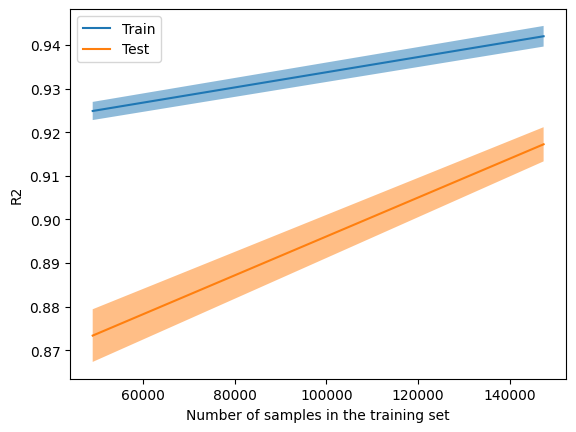

In [14]:
kneighbors = KNeighborsRegressor(n_neighbors = 5)
bagged_kn = BaggingRegressor(kneighbors, n_estimators = 3)

# cv_score = cross_val_score(bagged_kn, X_train_proc, y_train, scoring = "r2", cv=5, n_jobs = -1)
# cv_score

LearningCurveDisplay.from_estimator(bagged_kn, X_proc, y, train_sizes = [0.1, 0.3], scoring = "r2", cv=5, n_jobs = -1) 

### XGBoost

In [9]:
# xgb_cpu = XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.1)

In [33]:
xgb = XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.1, device = "cuda")

In [34]:
# cv_score = cross_val_score(bagged_kn, X_train_proc, y_train, scoring = "r2", cv=5, n_jobs = -1)
# cv_score

In [35]:
# xgb_cpu.fit(X_train, y_train,
#     # evaluate loss at each iteration
#     eval_set=[(X_train, y_train), (X_val, y_val)]#,  
#     # stop iterating when eval loss increases 5 times in a row
#     # early_stopping_rounds=5
# )

In [36]:
xgb.fit(X_train, y_train,
    # evaluate loss at each iteration
    eval_set=[(X_train, y_train), (X_val, y_val)]#,  
    # stop iterating when eval loss increases 5 times in a row
    # early_stopping_rounds=5
)

[0]	validation_0-rmse:4912.83545	validation_1-rmse:5010.58079
[1]	validation_0-rmse:4435.80423	validation_1-rmse:4523.68378
[2]	validation_0-rmse:4006.41217	validation_1-rmse:4084.99561
[3]	validation_0-rmse:3619.47028	validation_1-rmse:3691.12375
[4]	validation_0-rmse:3270.69043	validation_1-rmse:3336.32968
[5]	validation_0-rmse:2956.44194	validation_1-rmse:3015.99362
[6]	validation_0-rmse:2673.44874	validation_1-rmse:2730.61721
[7]	validation_0-rmse:2418.29680	validation_1-rmse:2470.99765
[8]	validation_0-rmse:2187.55525	validation_1-rmse:2236.80697
[9]	validation_0-rmse:1980.21284	validation_1-rmse:2026.04554
[10]	validation_0-rmse:1792.63882	validation_1-rmse:1837.37639
[11]	validation_0-rmse:1623.70179	validation_1-rmse:1662.20232
[12]	validation_0-rmse:1471.71495	validation_1-rmse:1510.31235
[13]	validation_0-rmse:1334.59861	validation_1-rmse:1370.75029
[14]	validation_0-rmse:1209.77406	validation_1-rmse:1246.26900
[15]	validation_0-rmse:1096.95621	validation_1-rmse:1131.76767
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

#### Scoring the XGBoost model

In [37]:
y_pred_val = xgb.predict(X_val)
y_pred_val

array([5550.177  , 1497.0227 , 3943.783  , ..., 3397.4453 ,  297.82983,
       8925.183  ], dtype=float32)

In [38]:
y_pred_test = xgb.predict(X_test)
y_pred_test

array([ 5888.641  , 13447.425  ,   115.00366, ...,  3864.3281 ,
       20310.965  ,  1241.8059 ], dtype=float32)

In [39]:
# xgb_cpu.predict(X_val)

In [40]:
xgb.score(X_val, y_val)

0.9974509462728971

In [41]:
xgb.score(X_test, y_test)

0.9980012450004663

In [42]:
mean_squared_error(y_val, y_pred_val)

78558.82543294432

In [43]:
np.sqrt(mean_squared_error(y_val, y_pred_val))

280.28347334965065

In [44]:
mean_absolute_error(y_val, y_pred_val)

28.838850101687076

In [45]:
y_test.head()

SalesKey
2384552     5880.0000
2384557    13278.6220
2384565      115.4615
2384572    10887.2000
2384585      359.8800
Name: SalesAmount, dtype: float64

#### Looks pretty good! The model's SalesAmount predictions are on average off by only 27.5 USD!

#### TO DO: Plot observed and predicted data

In [46]:
y_pred_test

array([ 5888.641  , 13447.425  ,   115.00366, ...,  3864.3281 ,
       20310.965  ,  1241.8059 ], dtype=float32)

In [47]:
y_test

SalesKey
2384552     5880.0000
2384557    13278.6220
2384565      115.4615
2384572    10887.2000
2384585      359.8800
              ...    
3406074     5235.5240
3406075      140.3000
3406083     3854.8715
3406088    20310.7500
3406089     1226.4000
Name: SalesAmount, Length: 184025, dtype: float64

In [50]:
def plot_prediction(y_pred_val, y_pred_test, y_train, y_val, y_test, upper=None, lower=None):
        is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
        # Prepare plot series
        y_pred_val_series = pd.Series(y_pred_val, index = y_val.index)
        y_pred_test_series = pd.Series(y_pred_test, index = y_test.index)
        lower_val_series = pd.Series(upper, index = y_val.index) if is_confidence_int else None
        upper_val_series = pd.Series(lower, index = y_val.index) if is_confidence_int else None
        lower_test_series = pd.Series(upper, index = y_test.index) if is_confidence_int else None
        upper_test_series = pd.Series(lower, index = y_test.index) if is_confidence_int else None

        # Plot
        plt.figure(figsize=(10,4), dpi=100)
        plt.plot(y_train, label='training', color='black')
        plt.plot(y_val, label='validation data', color='black', ls='--')
        plt.plot(y_test, label='test data', color='black', ls=':')
        if is_confidence_int:
            plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
        plt.title('Prediction vs Actual Validation and Test Values')
        plt.plot(y_pred_val_series, label='val prediction', color='blue')
        plt.plot(y_pred_test_series, label='test prediction', color='lightblue')
        plt.legend(loc='upper left', fontsize=8);

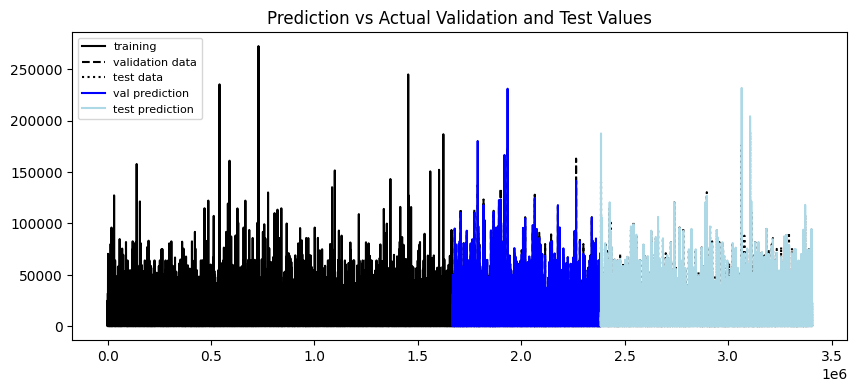

In [51]:
plot_prediction(y_pred_val, y_pred_test, y_train, y_val, y_test)